## Overcooked AI data Preliminary Analysis.ipynb

# Dataset Credits

@misc{hulle2024eyesgamedecipheringimplicit,
      title={Eyes on the Game: Deciphering Implicit Human Signals to Infer Human Proficiency, Trust, and Intent}, 
      author={Nikhil Hulle and Stéphane Aroca-Ouellette and Anthony J. Ries and Jake Brawer and Katharina von der Wense and Alessandro Roncone},
      year={2024},
      eprint={2407.03298},
      archivePrefix={arXiv},
      primaryClass={cs.HC},
      url={https://arxiv.org/abs/2407.03298}, 
}

Original dataset location: https://o365coloradoedu.sharepoint.com/sites/CS-HAI_Teaming_EyeGaze_Data/Shared%20Documents/Forms/AllItems.aspx?id=%2Fsites%2FCS%2DHAI%5FTeaming%5FEyeGaze%5FData%2FShared%20Documents%2FRO%2DMAN%5F2024&p=true&ga=1 

Steps
1. Download the above dataset and copy them to 'oai_dataset' directory.
2. Install necessary processing libraries to a Conda environment with Python 3.10.
3. Run the scripts.

In [58]:
## Python (Environment Python 3.10)


import os
import pandas as pd
import json
import pyxdf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def load_stream2_data(xdf_file):
    # Load the xdf file
    data, _ = pyxdf.load_xdf(xdf_file)
    
    # Extract Stream 2 (GameData)
    stream2 = next(stream for stream in data if stream['info']['name'][0] == 'GameData')
    
    # Extract time-stamped GameData
    timestamps = stream2['time_stamps']
    samples = stream2['time_series']
    
    # Parse samples (GameData JSON strings)
    parsed_samples = [json.loads(sample[0]) for sample in samples]
    
    return timestamps, parsed_samples

def process_gamedata(timestamps, samples):
    rows = []
    for ts, sample in zip(timestamps, samples):
        # Parse the 'state' field if it is a JSON string
        if isinstance(sample['state'], str):
            sample['state'] = json.loads(sample['state'])
        
        row = {
            "timestamp": ts,
            "trial_id": sample['trial_id'],
            "user_id": sample['user_id'],
            "time_elapsed": sample['time_elapsed'],
            "time_left": sample['time_left'],
            "score": sample['score'],
            "reward": sample['reward'],
            "num_collisions": sample['num_collisions'],
            "cur_gameloop": sample['cur_gameloop']
        }
        # Add player-specific and layout information
        for idx, player in enumerate(sample['state']['players']):
            row[f'player{idx+1}_position'] = player['position']
            row[f'player{idx+1}_orientation'] = player['orientation']
            row[f'player{idx+1}_held_object'] = player['held_object']
        
        rows.append(row)
        # print(row)
    
    # Convert to DataFrame
    df = pd.DataFrame(rows)
    return df


def merge_with_likert_data(game_data_df, likert_csv):
    # Load Likert scale data
    likert_df = pd.read_csv(likert_csv)
    
    # Rename column to ensure consistency
    if 'Trial_ID' in likert_df.columns:
        likert_df.rename(columns={"Trial_ID": "trial_id"}, inplace=True)
    
    # Check for missing trial_id columns
    if 'trial_id' not in game_data_df.columns:
        raise KeyError("Column 'trial_id' not found in game data.")
    if 'trial_id' not in likert_df.columns:
        raise KeyError("Column 'trial_id' not found in Likert data.")
    
    # Merge based on trial_id
    merged_df = game_data_df.merge(likert_df, on='trial_id', how='inner')
    
    return merged_df


def normalize_features(df, exclude_cols):
    # Select only numeric columns for normalization
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.difference(exclude_cols)
    
    # Normalize using Min-Max Scaling
    scaler = MinMaxScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    
    return df, scaler



def preprocess_game_data(df):
    # Split player positions into separate columns for x and y
    df[['player1_pos_x', 'player1_pos_y']] = pd.DataFrame(df['player1_position'].tolist(), index=df.index)
    df[['player2_pos_x', 'player2_pos_y']] = pd.DataFrame(df['player2_position'].tolist(), index=df.index)

    # Map orientations to Overcooked directions
    direction_mapping = {
        (0, -1): 1, #"NORTH",
        (0, 1): 2, #"SOUTH",
        (1, 0): 3, #"EAST",
        (-1, 0): 4 #"WEST"
    }
    df['player1_direction'] = df['player1_orientation'].apply(lambda x: direction_mapping.get(tuple(x), "UNKNOWN"))
    df['player2_direction'] = df['player2_orientation'].apply(lambda x: direction_mapping.get(tuple(x), "UNKNOWN"))

    # Flatten player 1's held object details
    df['player1_object_name'] = df['player1_held_object'].apply(lambda x: x.get('name') if isinstance(x, dict) else None)
    df['player1_object_pos_x'] = df['player1_held_object'].apply(lambda x: x.get('position', [None, None])[0] if isinstance(x, dict) else None)
    df['player1_object_pos_y'] = df['player1_held_object'].apply(lambda x: x.get('position', [None, None])[1] if isinstance(x, dict) else None)

    # Flatten player 2's held object details
    df['player2_object_name'] = df['player2_held_object'].apply(lambda x: x.get('name') if isinstance(x, dict) else None)
    df['player2_object_pos_x'] = df['player2_held_object'].apply(lambda x: x.get('position', [None, None])[0] if isinstance(x, dict) else None)
    df['player2_object_pos_y'] = df['player2_held_object'].apply(lambda x: x.get('position', [None, None])[1] if isinstance(x, dict) else None)

    for player in [1, 2]:
        # Process soup object details (e.g., for soups held by player 1)
        df[f'player{player}_soup_is_cooking'] = df[f'player{player}_held_object'].apply(lambda x: x.get('is_cooking') if isinstance(x, dict) else None)
        df[f'player{player}_soup_is_ready'] = df[f'player{player}_held_object'].apply(lambda x: x.get('is_ready') if isinstance(x, dict) else None)
        df[f'player{player}_soup_cooking_tick'] = df[f'player{player}_held_object'].apply(lambda x: x.get('cooking_tick') if isinstance(x, dict) else None)
        df[f'player{player}_soup_is_idle'] = df[f'player{player}_held_object'].apply(lambda x: x.get('is_idle') if isinstance(x, dict) else None)
        df[f'player{player}_soup_cook_time'] = df[f'player{player}_held_object'].apply(lambda x: x.get('cook_time') if isinstance(x, dict) else None)
        df[f'player{player}_soup__cooking_tick'] = df[f'player{player}_held_object'].apply(lambda x: x.get('_cooking_tick') if isinstance(x, dict) else None)


    # Process soup object details and _ingredients field for both players
    def extract_ingredients_features(held_object):
        if not isinstance(held_object, dict) or '_ingredients' not in held_object:
            return pd.Series([None, None, None, None, None])
        
        ingredients = held_object['_ingredients']
        # Extract positions
        positions = [ing['position'] for ing in ingredients if 'position' in ing]
        unique_positions = list(set(tuple(pos) for pos in positions))
        
        # Compute position statistics
        mean_position = np.mean(positions, axis=0) if positions else [None, None]
        position_variance = np.var(positions, axis=0).sum() if positions else None
        
        # Count metrics
        ingredient_count = len(ingredients)
        unique_position_count = len(unique_positions)

        return pd.Series([ingredient_count, unique_position_count, position_variance, mean_position[0], mean_position[1]])
    
    # Apply feature extraction to both players' held objects
    for player in [1, 2]:
        ingredient_features = df[f'player{player}_held_object'].apply(lambda x: extract_ingredients_features(x))
        # print(ingredient_features)
        ingredient_features.columns = [
            f'player{player}_ingredient_count',
            f'player{player}_unique_position_count',
            f'player{player}_position_variance',
            f'player{player}_mean_position_x',
            f'player{player}_mean_position_y'
        ]
        df = pd.concat([df, ingredient_features], axis=1)

    # Drop original nested columns to clean up the DataFrame
    df = df.drop(columns=[
        'player1_position', 'player2_position', 
        'player1_held_object', 'player2_held_object', 
        'player1_orientation', 'player2_orientation'
    ])

    return df



def save_merged_files_per_participant(dataset_path, output_path):
    for participant_folder in os.listdir(dataset_path):
        participant_path = os.path.join(dataset_path, participant_folder)
        
        # Check if it's a folder
        if os.path.isdir(participant_path):
            xdf_file = None
            likert_csv = None
            for file in os.listdir(participant_path):
                if file.endswith(".xdf"):
                    xdf_file = os.path.join(participant_path, file)
                elif file.startswith("likert") and file.endswith(".csv"):
                    likert_csv = os.path.join(participant_path, file)
            
            print(xdf_file, likert_csv)
            
            if xdf_file and likert_csv:
                # Process and merge data
                timestamps, samples = load_stream2_data(xdf_file)
                game_data_df = process_gamedata(timestamps, samples)
                processed_game_data_df = preprocess_game_data(game_data_df)
                merged_df = merge_with_likert_data(processed_game_data_df, likert_csv)
                
                # Save merged data
                output_file = os.path.join(output_path, f"{participant_folder}_v4.csv")
                merged_df.to_csv(output_file, index=False)
                print(f"Saved: {output_file}")


dataset_path = "oai_dataset"
output_path = "oai_dataset_processed"
os.makedirs(output_path, exist_ok=True)  # Ensure output folder exists
save_merged_files_per_participant(dataset_path, output_path)

print("Preprocessing complete. Data saved to 'preprocessed_oai_data.csv'.")


oai_dataset/AF1042/oaiET_AF1042.xdf oai_dataset/AF1042/likert_answers_AF1042.csv
Saved: oai_dataset_processed/AF1042_v4.csv
oai_dataset/AF1045/oaiET_AF1045.xdf oai_dataset/AF1045/likert_answers_AF1045.csv
Saved: oai_dataset_processed/AF1045_v4.csv
None oai_dataset/CU2044/likert_answers_CU2044.csv
oai_dataset/CU2017/oaiET_CU2017.xdf oai_dataset/CU2017/likert_answers_CU2017.csv
Saved: oai_dataset_processed/CU2017_v4.csv
oai_dataset/CU2028/oaiET_CU2028.xdf oai_dataset/CU2028/likert_answers_CU2028.csv
Saved: oai_dataset_processed/CU2028_v4.csv
oai_dataset/AF1020/oaiET_AF1020.xdf oai_dataset/AF1020/likert_answers_AF1020.csv
Saved: oai_dataset_processed/AF1020_v4.csv
oai_dataset/CU2010/oaiET_CU2010.xdf oai_dataset/CU2010/likert_answers_CU2010.csv
Saved: oai_dataset_processed/CU2010_v4.csv
oai_dataset/CU2026/oaiET_CU2026.xdf oai_dataset/CU2026/likert_answers_CU2026.csv
Saved: oai_dataset_processed/CU2026_v4.csv
oai_dataset/CU2019/oaiET_CU2019.xdf oai_dataset/CU2019/likert_answers_CU2019.csv
S

In [11]:
def load_all_merged_data(output_path):
    all_data = []
    for file in os.listdir(output_path):
        if file.endswith("_v4.csv"):
            file_path = os.path.join(output_path, file)
            df = pd.read_csv(file_path)
            all_data.append(df)
    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df


combined_df = load_all_merged_data(output_path)


In [12]:
combined_df.head(100)

,timestamp,trial_id,user_id,time_elapsed,time_left,score,reward,num_collisions,cur_gameloop,player1_pos_x,...,player2_ingredient_count,player2_unique_position_count,player2_position_variance,player2_mean_position_x,player2_mean_position_y,q0,q1,q2,q3,q4
0,1935.835984,1,CU2050,0.2,79.8,0,0,0,1,3,...,NaN,NaN,NaN,NaN,NaN,-3,3,1,-2,-3
1,1936.045371,1,CU2050,0.4,79.6,0,0,0,2,3,...,NaN,NaN,NaN,NaN,NaN,-3,3,1,-2,-3
2,1936.253235,1,CU2050,0.6,79.4,0,0,0,3,3,...,NaN,NaN,NaN,NaN,NaN,-3,3,1,-2,-3
3,1936.462363,1,CU2050,0.8,79.2,0,0,0,4,3,...,NaN,NaN,NaN,NaN,NaN,-3,3,1,-2,-3
4,1936.671418,1,CU2050,1.0,79.0,0,0,0,5,2,...,NaN,NaN,NaN,NaN,NaN,-3,3,1,-2,-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1955.677341,1,CU2050,19.2,60.8,0,0,8,96,6,...,NaN,NaN,NaN,NaN,NaN,-3,3,1,-2,-3
96,1955.886390,1,CU2050,19.4,60.6,0,0,8,97,6,...,NaN,NaN,NaN,NaN,NaN,-3,3,1,-2,-3
97,1956.095501,1,CU2050,19.6,60.4,0,0,8,98,6,...,NaN,NaN,NaN,NaN,NaN,-3,3,1,-2,-3
98,1956.303389,1,CU2050,19.8,60.2,0,0,8,99,6,...,NaN,NaN,NaN,NaN,NaN,-3,3,1,-2,-3


In [13]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import pandas as pd
import numpy as np

def preprocess_for_clustering(df):
    # Copy the DataFrame to avoid modifying the original
    df = df.copy()

    # Initialize encoders and scalers
    label_encoders = {}
    numeric_scaler = MinMaxScaler()

    # Convert all non-numeric columns to consistent types
    for column in df.columns:
        if df[column].dtype == 'object' or df[column].dtype.name == 'category' or df[column].dtype == 'bool':
            # Convert booleans to strings
            df[column] = df[column].apply(lambda x: str(x) if isinstance(x, bool) else x)
            # Convert all values to strings to ensure uniform types
            df[column] = df[column].astype(str)
            # Apply label encoding
            label_encoders[column] = LabelEncoder()
            df[column] = label_encoders[column].fit_transform(df[column])

    # Handle missing values for numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        df[col] = df[col].fillna(df[col].mean())

    # Normalize all numeric columns
    # df[numeric_columns] = numeric_scaler.fit_transform(df[numeric_columns])

    return df, label_encoders, numeric_scaler


processed_df, encoders, scaler = preprocess_for_clustering(combined_df)
print(processed_df)

processed_df.to_csv("final_oai.csv")

           timestamp  trial_id  user_id  time_elapsed  time_left  score  \
0       1.935836e+03         1       73           0.2       79.8      0   
1       1.936045e+03         1       73           0.4       79.6      0   
2       1.936253e+03         1       73           0.6       79.4      0   
3       1.936462e+03         1       73           0.8       79.2      0   
4       1.936671e+03         1       73           1.0       79.0      0   
...              ...       ...      ...           ...        ...    ...   
561646  1.032396e+06        18       50          79.4        0.6    240   
561647  1.032396e+06        18       50          79.6        0.4    240   
561648  1.032397e+06        18       50          79.8        0.2    240   
561649  1.032397e+06        18       50          80.0        0.0    240   
561650  1.032407e+06        18       50          54.6       25.4    160   

        reward  num_collisions  cur_gameloop  player1_pos_x  ...  \
0            0               0 

In [14]:
from sklearn.cluster import KMeans
## Clustering

# Exclude the last 5 columns (subjective ratings q0 to q4)
gameplay_features = processed_df.iloc[:, :-5]


# Perform clustering
kmeans = KMeans(n_clusters=2, random_state=42)
processed_df['cluster'] = kmeans.fit_predict(gameplay_features)


In [15]:
# List of subjective questions
subjective_questions = ['q0', 'q1', 'q2', 'q3', 'q4']
                       # ['team_fluency', 'perceived_role_significance', 'trust_in_agent', 'understanding_agent_actions', 'agent_cooperativeness']

# Correlation analysis
correlations = processed_df.corr()
selected_correlations = correlations[['cluster'] + subjective_questions]
print(selected_correlations)


                                    cluster        q0        q1        q2  \
timestamp                      9.010178e-01 -0.016574 -0.066923 -0.019686   
trial_id                      -1.357300e-06  0.076619  0.030291 -0.005614   
user_id                       -1.794407e-01  0.015302  0.001112  0.040028   
time_elapsed                  -5.202148e-07  0.000021 -0.000020  0.000016   
time_left                      5.202148e-07 -0.000021  0.000020 -0.000016   
score                          1.982060e-02  0.409580 -0.282088  0.377550   
reward                         2.716647e-03  0.054727 -0.037195  0.050191   
num_collisions                -2.662620e-03 -0.151994  0.053165 -0.119933   
cur_gameloop                  -5.202148e-07  0.000021 -0.000020  0.000016   
player1_pos_x                 -1.903887e-03  0.061974  0.049871  0.023930   
player1_pos_y                 -5.577611e-03  0.077811 -0.053391  0.072084   
player2_pos_x                  4.383093e-03  0.041031 -0.032672  0.034972   

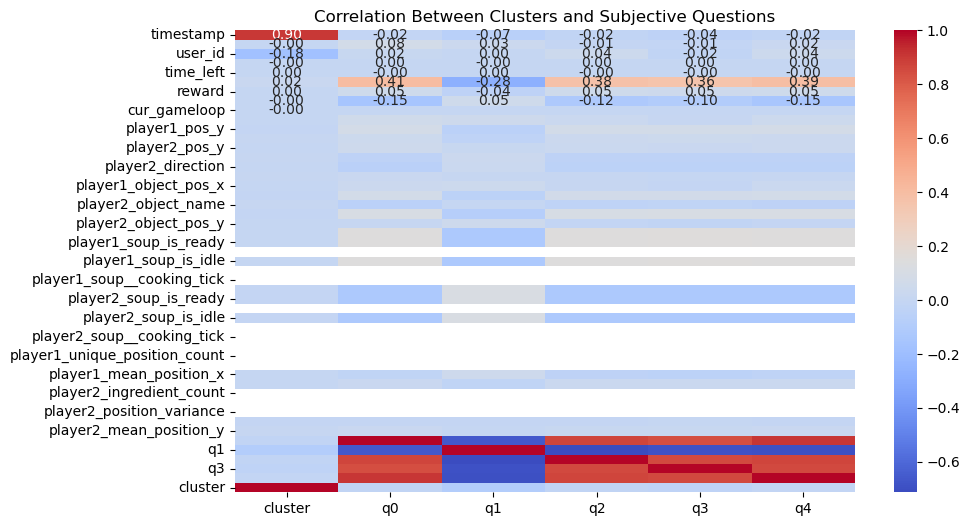

In [16]:
# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(selected_correlations, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Between Clusters and Subjective Questions")
plt.show()

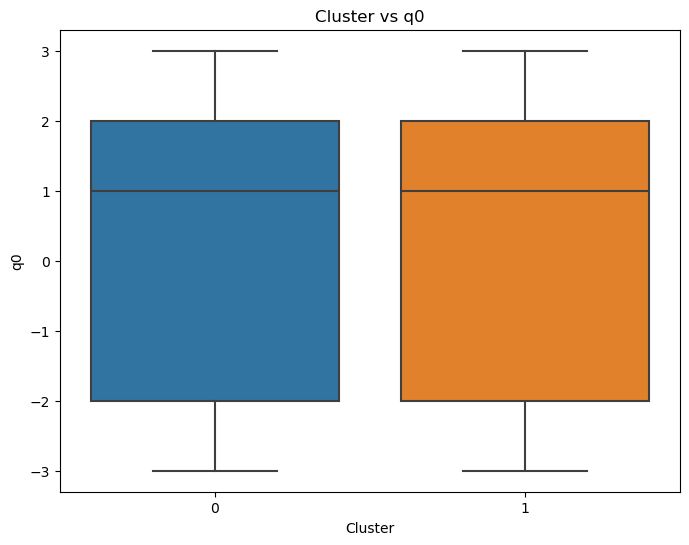

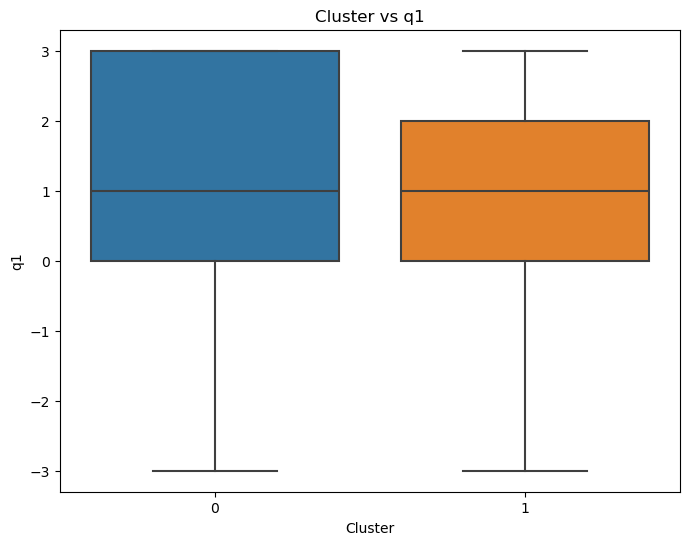

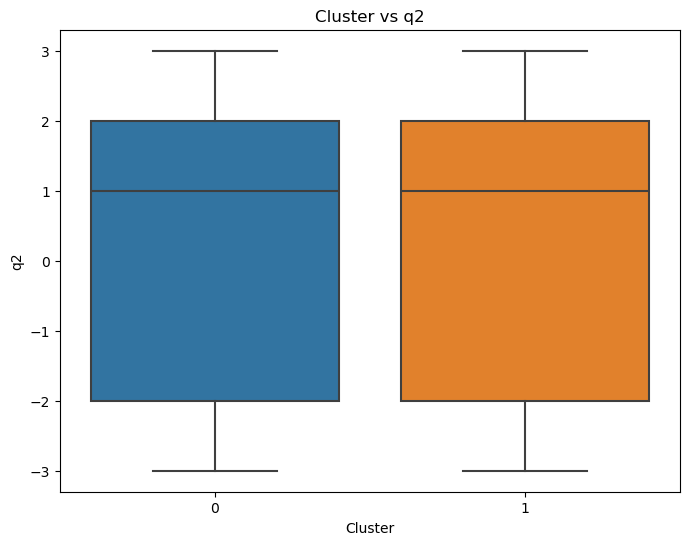

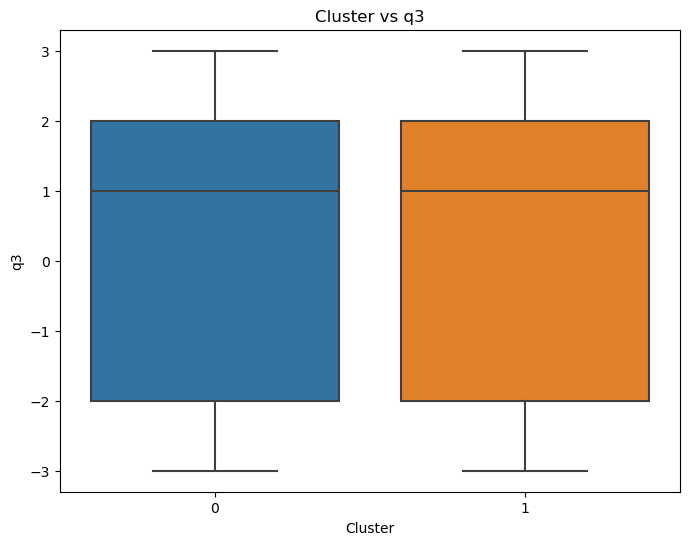

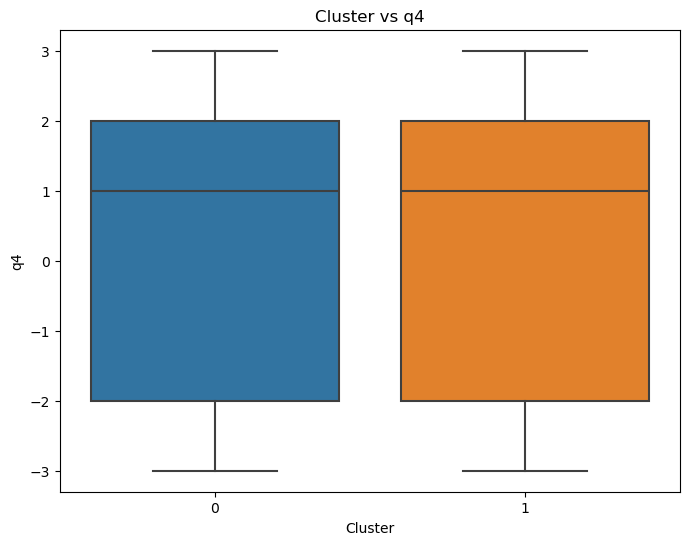

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

for question in subjective_questions:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='cluster', y=question, data=processed_df)
    plt.title(f'Cluster vs {question}')
    plt.xlabel('Cluster')
    plt.ylabel(question)
    plt.show()


In [18]:
# ## Clustering

# from sklearn.cluster import KMeans
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Number of clusters
# NUM_CLUSTERS = 3  # Adjust based on data exploration


# def cluster_gaming_data(game_data, subjective_ratings, num_clusters=NUM_CLUSTERS):
#     # Perform clustering
#     kmeans = KMeans(n_clusters=num_clusters, random_state=42)
#     game_data['cluster'] = kmeans.fit_predict(game_data)

#     # Add cluster labels to subjective ratings
#     clustered_data = game_data.groupby(['user_id', 'trial_id']).mean().reset_index()
#     merged_data = pd.merge(clustered_data, subjective_ratings, on=['user_id', 'trial_id'], how='inner')

#     return merged_data, kmeans


# def analyze_correlations(data, questions):
#     correlations = {}
#     for question in questions:
#         corr = data.corrwith(data[question], method='spearman')
#         correlations[question] = corr
#     return pd.DataFrame(correlations)



# def visualize_cluster_correlations(merged_data, questions):
#     for question in questions:
#         plt.figure(figsize=(10, 6))
#         sns.boxplot(x='cluster', y=question, data=merged_data)
#         plt.title(f'Cluster vs {question}')
#         plt.xlabel('Cluster')
#         plt.ylabel(question)
#         plt.show()


In [19]:
# # Assuming game_data and subjective_ratings DataFrames are ready
# questions = ['team_fluency', 'perceived_role_significance', 'trust_in_agent', 'understanding_agent_actions', 'agent_cooperativeness']

# gameplay_features = scalarized_data.iloc[:, :-5]

# merged_data, kmeans = cluster_gaming_data(processed_df, subjective_ratings, num_clusters=NUM_CLUSTERS)


In [20]:
# 

In [21]:
# visualize_cluster_correlations(merged_data, questions)


## Visualizations

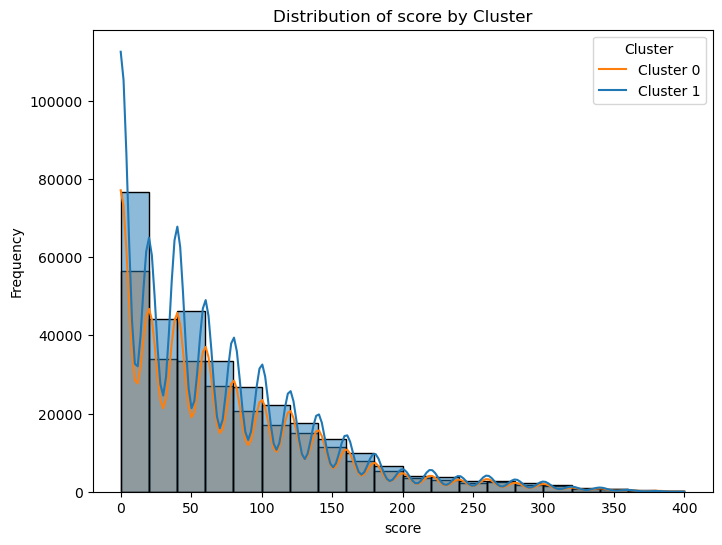

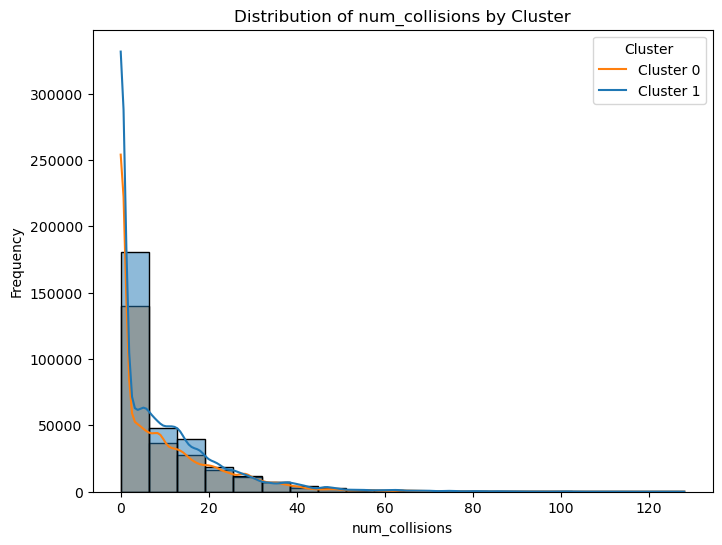

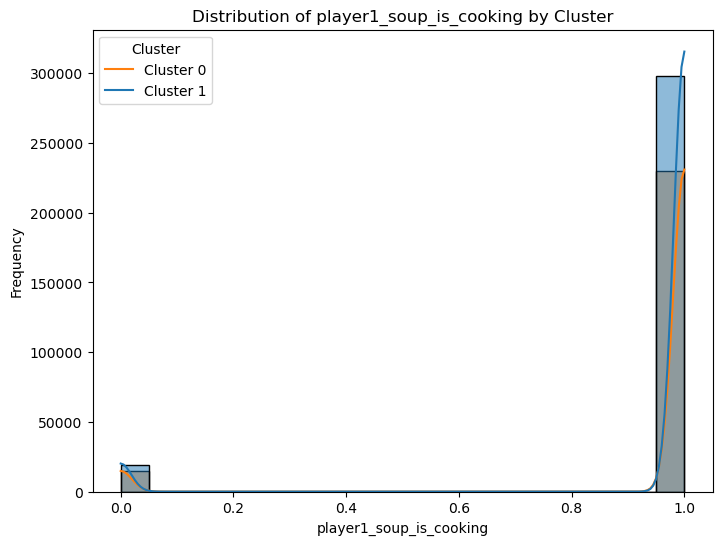

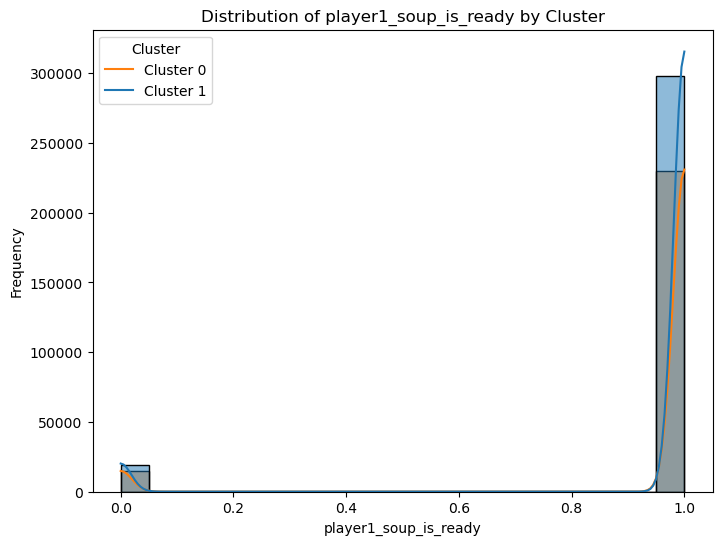

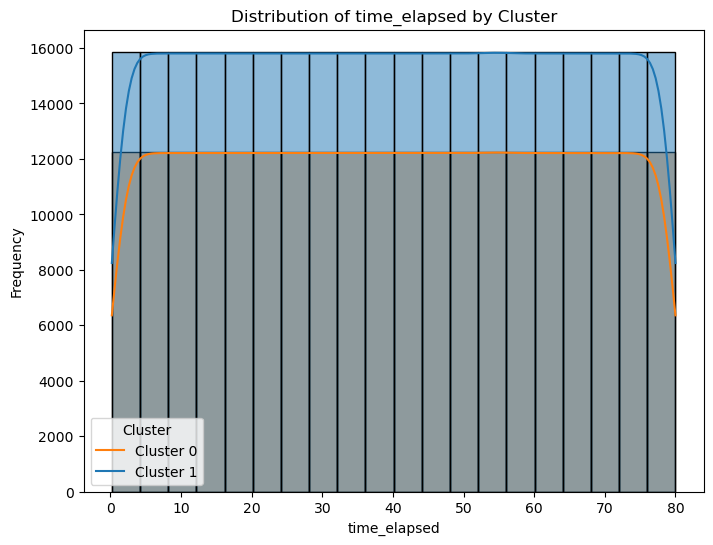

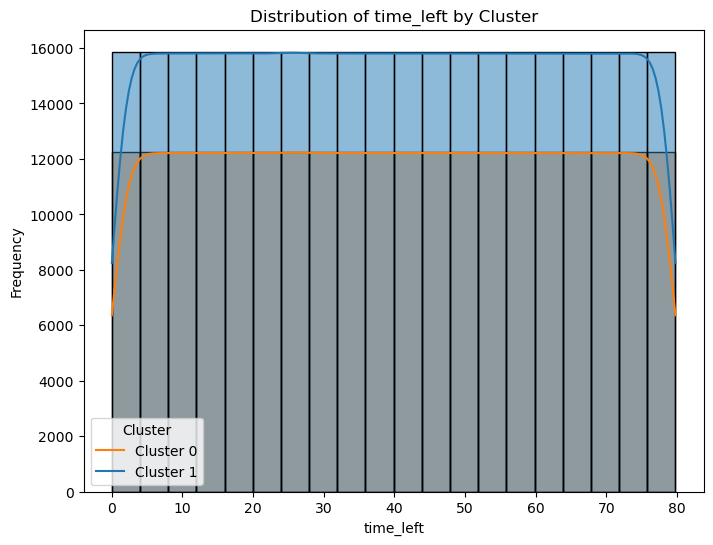

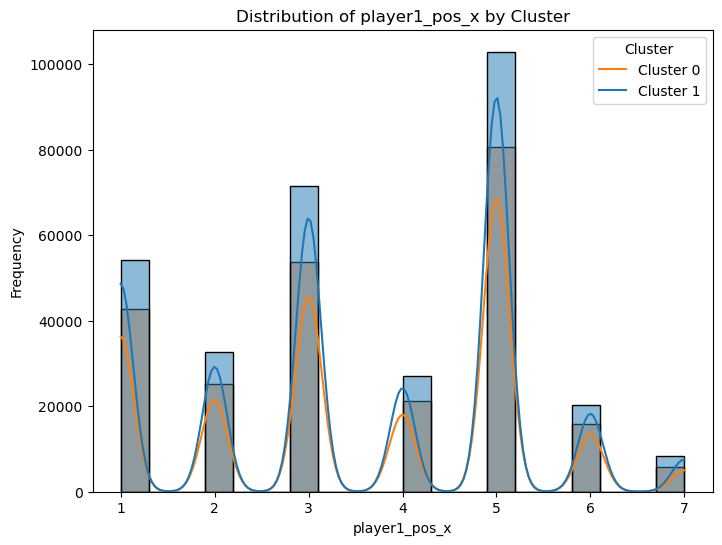

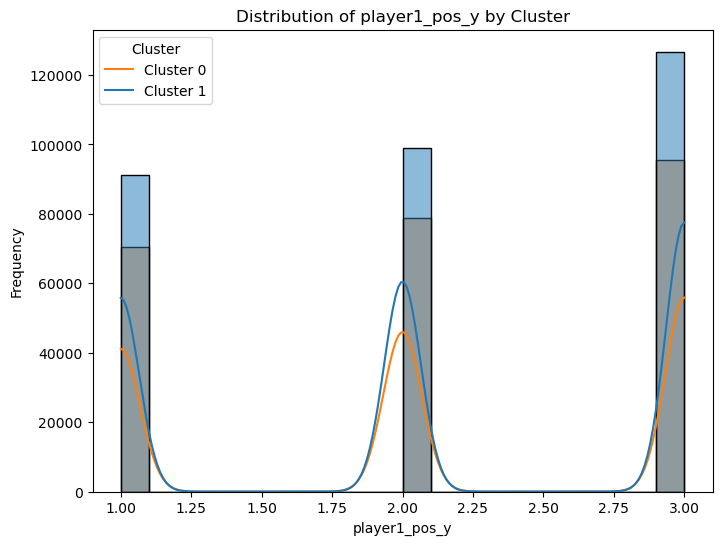

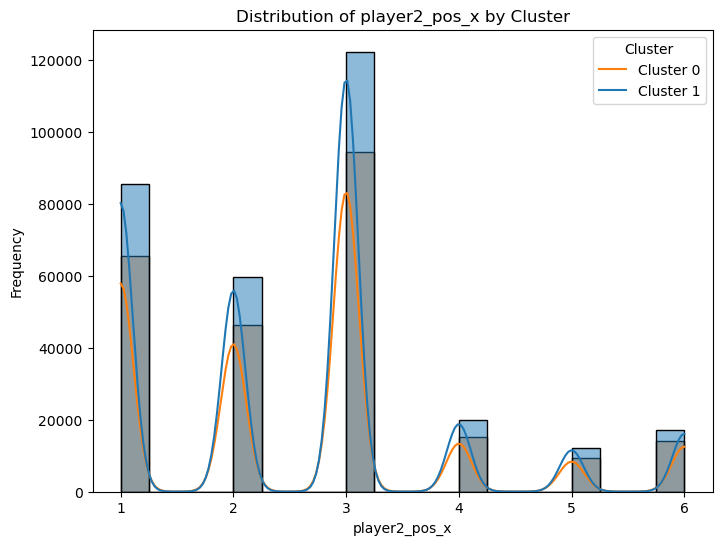

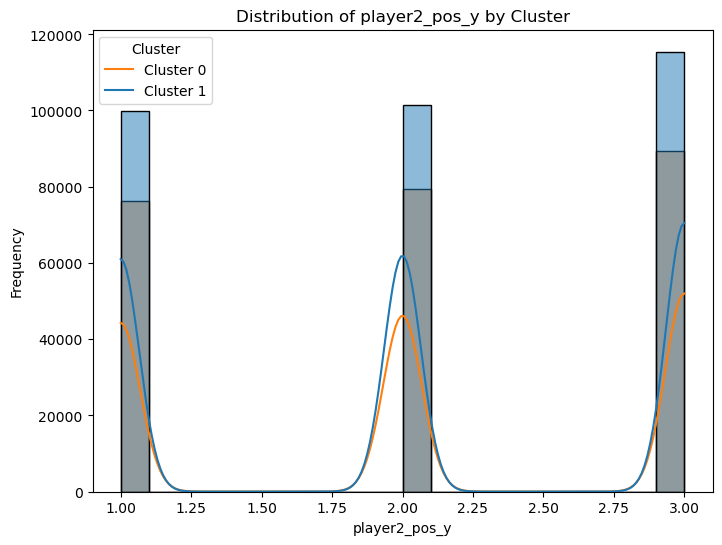

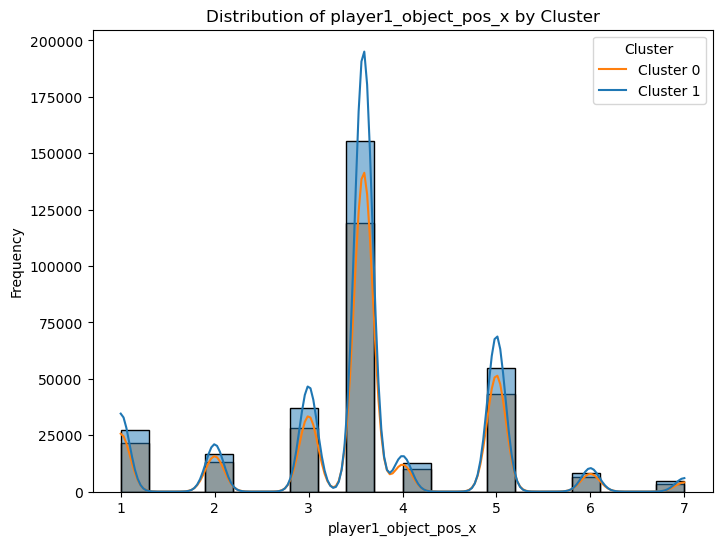

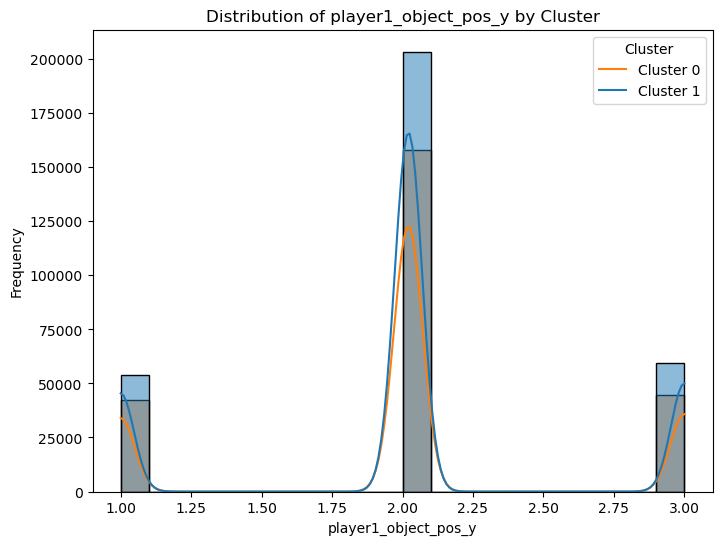

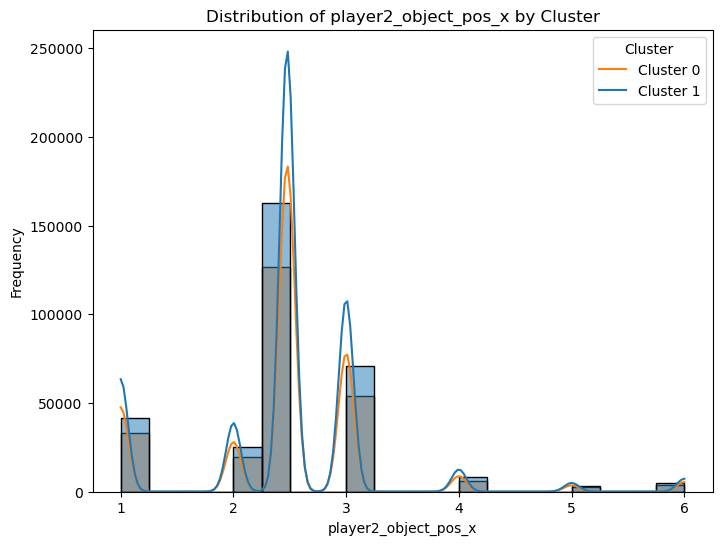

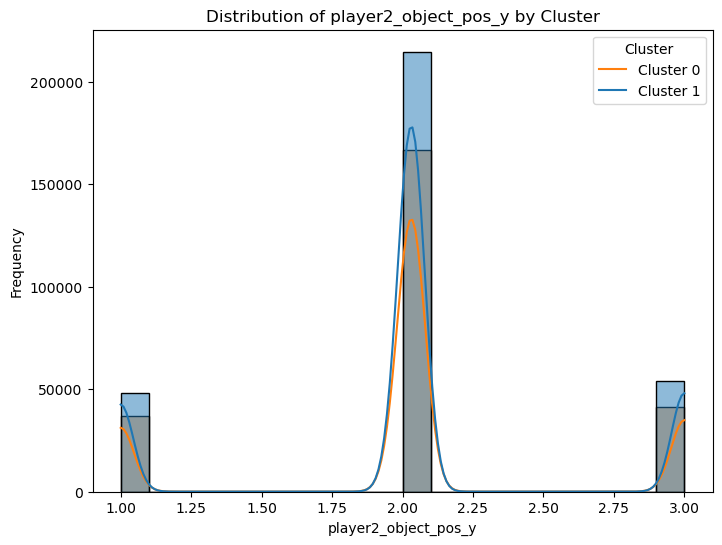

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Features to analyze
features = [
    'score', 'num_collisions', 'player1_soup_is_cooking', 
    'player1_soup_is_ready', 'time_elapsed', 'time_left', 
    'player1_pos_x', 'player1_pos_y', 'player2_pos_x', 
    'player2_pos_y', 'player1_object_pos_x', 'player1_object_pos_y', 
    'player2_object_pos_x', 'player2_object_pos_y'
]
# Plot distributions for each feature
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=processed_df, x=feature, hue='cluster', kde=True, bins=20)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend(title='Cluster', labels=[f'Cluster {i}' for i in sorted(processed_df["cluster"].unique())])
    plt.show()


## Analysis of Variance

In [32]:
# Select game features and subjective metrics
game_features = list(combined_df)[:-5]
# game_features = [
#     'score', 'num_collisions', 'time_elapsed', 'time_left', 
#     'player1_soup_is_cooking', 'player1_soup_is_ready', 'player2_soup_is_cooking', 'player2_soup_is_ready', 
#     'player1_pos_x', 'player1_pos_y', 'player2_pos_x', 'player2_pos_y'
# ]

In [46]:
from scipy.stats import f_oneway
import warnings 
warnings.filterwarnings("ignore")

'''
ANOVA:

F-statistic: Measures variance between cluster means relative to variance within clusters.
P-value: Determines statistical significance:
𝑝 ≤ 0.05
    p≤0.05: Significant differences exist between cluster means for that feature.
𝑝 > 0.05
    p>0.05: No significant difference detected.
'''

# Perform ANOVA for each feature
anova_results = {}
for feature in game_features:
    # Group data by cluster
    groups = [processed_df[processed_df['cluster'] == i][feature] for i in processed_df['cluster'].unique()]
    
    # Perform ANOVA
    f_stat, p_value = f_oneway(*groups)
    anova_results[feature] = {'F-statistic': f_stat, 'p-value': p_value}

# Convert results to a DataFrame for better readability
anova_results_df = pd.DataFrame(anova_results).T
anova_results_df.sort_values(by='p-value', inplace=True)
print("ANOVA Results:")
print(anova_results_df)


# There is a significant difference between clusters for score and num_collisions

ANOVA Results:
                                F-statistic       p-value
timestamp                      2.423194e+06  0.000000e+00
user_id                        1.868619e+04  0.000000e+00
score                          2.207340e+02  6.394149e-50
player1_object_pos_y           2.490471e+01  6.025306e-07
player2_soup_is_idle           2.439022e+01  7.868942e-07
player2_soup_is_ready          2.439022e+01  7.868942e-07
player2_soup_is_cooking        2.439022e+01  7.868942e-07
player2_mean_position_x        2.343422e+01  1.292931e-06
player2_object_name            1.853167e+01  1.671325e-05
player1_pos_y                  1.747330e+01  2.914150e-05
player1_object_name            1.741044e+01  3.012120e-05
player2_mean_position_y        1.377493e+01  2.060876e-04
player2_object_pos_x           1.376981e+01  2.066496e-04
player2_pos_x                  1.079033e+01  1.020378e-03
player1_direction              6.966309e+00  8.306093e-03
player2_pos_y                  5.009333e+00  2.521141e-02

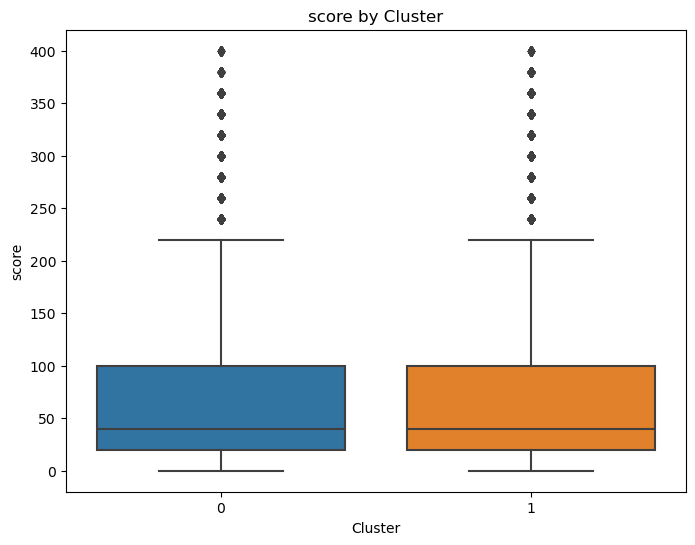

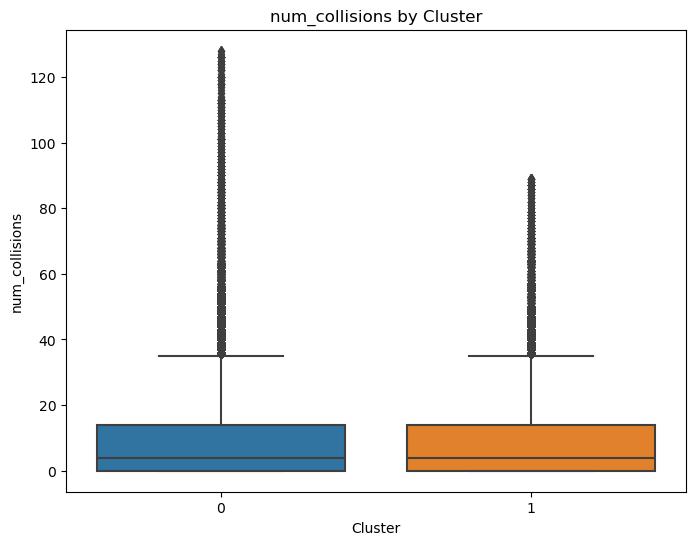

In [48]:
sig_features = ['score', 'num_collisions']
for feature in sig_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=processed_df, x='cluster', y=feature)
    plt.title(f'{feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()


## Correlation between game features and subjective metrics

In [50]:
combined_df.columns

Index(['timestamp', 'trial_id', 'user_id', 'time_elapsed', 'time_left',
       'score', 'reward', 'num_collisions', 'cur_gameloop', 'player1_pos_x',
       'player1_pos_y', 'player2_pos_x', 'player2_pos_y', 'player1_direction',
       'player2_direction', 'player1_object_name', 'player1_object_pos_x',
       'player1_object_pos_y', 'player2_object_name', 'player2_object_pos_x',
       'player2_object_pos_y', 'player1_soup_is_cooking',
       'player1_soup_is_ready', 'player1_soup_cooking_tick',
       'player1_soup_is_idle', 'player1_soup_cook_time',
       'player1_soup__cooking_tick', 'player2_soup_is_cooking',
       'player2_soup_is_ready', 'player2_soup_cooking_tick',
       'player2_soup_is_idle', 'player2_soup_cook_time',
       'player2_soup__cooking_tick', 'player1_ingredient_count',
       'player1_unique_position_count', 'player1_position_variance',
       'player1_mean_position_x', 'player1_mean_position_y',
       'player2_ingredient_count', 'player2_unique_position_count'

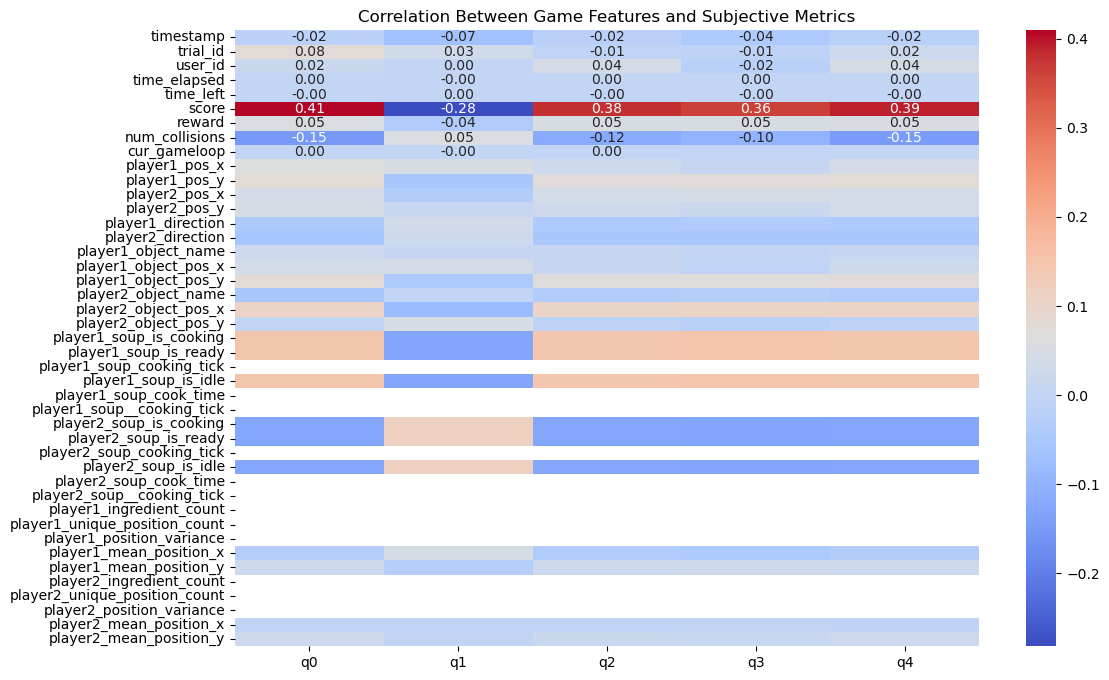

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

subjective_metrics = ['q0', 'q1', 'q2', 'q3', 'q4']

# Compute correlation matrix
correlation_matrix = processed_df[game_features + subjective_metrics].corr()

# Extract correlations between game features and subjective metrics
correlations = correlation_matrix.loc[game_features, subjective_metrics]

# Visualize correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Between Game Features and Subjective Metrics")
plt.show()


Feature Importance (Linear Regression):
                                         q0            q1            q2  \
timestamp                     -1.107284e-07 -1.561772e-07 -1.098772e-07   
trial_id                       4.187538e-03  2.719848e-02 -2.922220e-02   
user_id                        2.435264e-03 -1.104594e-03  4.815317e-03   
time_elapsed                  -2.308713e-03  1.470388e-03 -2.241061e-03   
time_left                      2.308713e-03 -1.470388e-03  2.241061e-03   
score                          2.731854e-02 -1.700417e-02  2.626851e-02   
reward                        -1.838658e-02  1.377106e-02 -1.844300e-02   
num_collisions                 2.569100e-02 -2.050911e-02  2.759458e-02   
cur_gameloop                  -1.154357e-02  7.351939e-03 -1.120531e-02   
player1_pos_x                 -7.493281e-02  1.308100e-01 -1.074251e-01   
player1_pos_y                  2.045773e-02 -1.455449e-02  1.150345e-02   
player2_pos_x                  6.958286e-02 -4.345770e-02  5

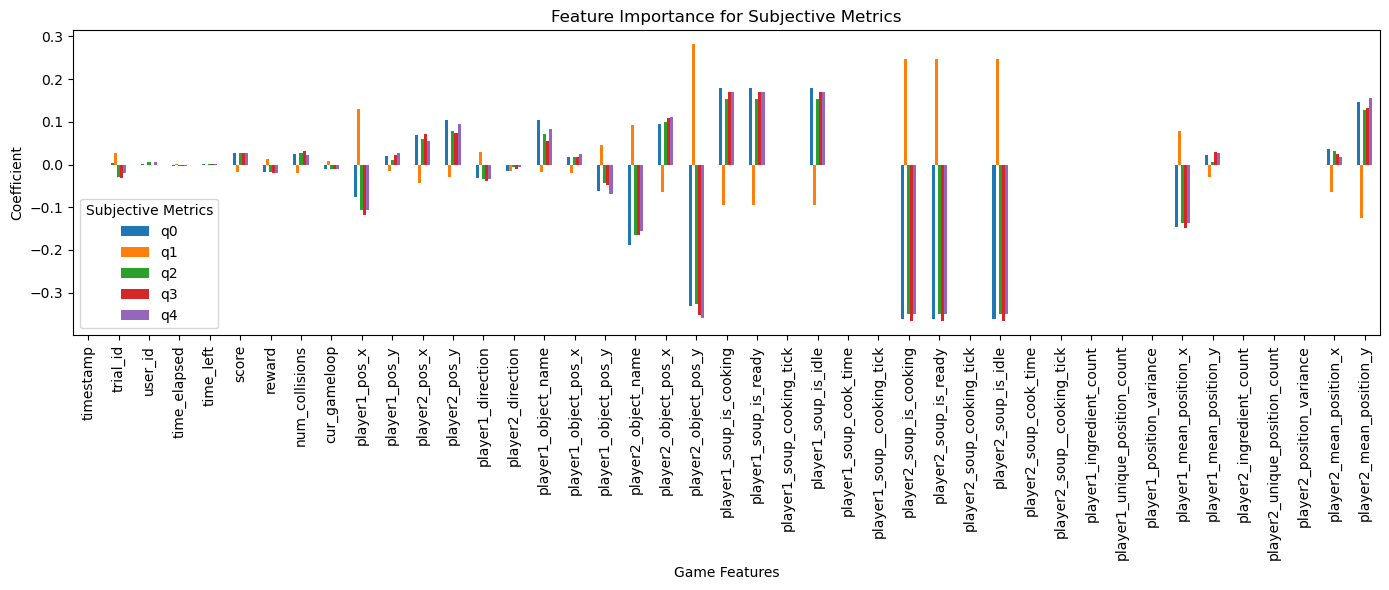

In [53]:
from sklearn.linear_model import LinearRegression
import pandas as pd

# Prepare results storage
feature_importance = {}

# Loop through each subjective metric
for metric in subjective_metrics:
    # Fit linear regression
    X = processed_df[game_features]
    y = processed_df[metric]
    model = LinearRegression()
    model.fit(X, y)
    
    # Store feature importance
    feature_importance[metric] = model.coef_

# Convert to DataFrame for better visualization
importance_df = pd.DataFrame(feature_importance, index=game_features)
print("Feature Importance (Linear Regression):")
print(importance_df)

# Visualize feature importance
importance_df.plot(kind='bar', figsize=(14, 6), title="Feature Importance for Subjective Metrics")
plt.xlabel("Game Features")
plt.ylabel("Coefficient")
plt.legend(title="Subjective Metrics")
plt.tight_layout()
plt.show()


In [56]:
from scipy.stats import f_oneway

# Analyze the effect of 'score' on 'trust_in_agent'
feature = 'score'
metric = 'q4' #'trust_in_agent'

# Divide 'score' into quantiles for group analysis
processed_df['score_group'] = pd.qcut(processed_df[feature], q=3, labels=['Low', 'Medium', 'High'])

# Perform ANOVA
groups = [processed_df[processed_df['score_group'] == grp][metric] for grp in ['Low', 'Medium', 'High']]
f_stat, p_value = f_oneway(*groups)

print(f"ANOVA for {feature} on {metric}: F-statistic = {f_stat:.2f}, p-value = {p_value:.4f}")


ANOVA for score on q4: F-statistic = 40301.21, p-value = 0.0000
